# Highway Tollgate Travel Time Prediction
## Machine Learning for Cities Final Project
### By Muci Yu (my1826), Songjian Li (sl4729), Pengzi Li (pl1840)

[1. Import Data](#Import_data)

[2. Feature Engineering](#Feature_Engineering)

- [2.1 Construct a dataframe that based on each vehicle](#Consturct_a_dataframe_that_base_on_each_vehicle)

- [2.2 Starting time](#starting_time)

- [2.3 Target variable](#target_variable)

- [2.4 Route feature](#route_feature)

- [2.5 Average road width and length](#average_road_width_and_length)

- [2.6 Same route car](#same_route_car)

- [2.7 Weather-related features](#Weather_related_feature)

- [2.8 Peak hour](#peak_hour)

- [2.9 Daily feature](#daily_feature)

- [2.10 Weekday/weekend](#weekday/weekend)

[3. Train/test Split](#Train/test_split)

[4. Drop Outliers](#Drop_outliers)

[5. Target Variable Distribution](#Travel_time_histogram)

[6. Model](#Model)

- [6.1 Base line](#Base_Line)

- [6.2 Linear Regression](#Linear_regression)

- [6.3 Random Forest Regression](#random_forest)

- [6.4 XGBoost](#xgboost)

[7. Conclusion](#Conclusion)

## Import_data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import calendar
pd.set_option('display.max_columns', 500)
%matplotlib inline

import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
import pickle
import xgboost as xgb
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, mean_absolute_error
from sklearn.datasets import load_iris, load_digits, load_boston
from sklearn.ensemble import RandomForestRegressor

In [3]:
!ls dataSets/training

links (table 3).csv                volume(table 6)_training.csv
routes (table 4).csv               weather (table 7)_training.csv
trajectories(table 5)_training.csv


In [4]:
training_path1 = "dataSets/training/"
links = pd.read_csv(training_path1+'links (table 3).csv')
print(links.shape)
print(links.info())
links.head()

(24, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 7 columns):
link_id       24 non-null int64
length        24 non-null int64
width         24 non-null int64
lanes         24 non-null int64
in_top        21 non-null object
out_top       21 non-null object
lane_width    24 non-null int64
dtypes: int64(5), object(2)
memory usage: 1.4+ KB
None


,link_id,length,width,lanes,in_top,out_top,lane_width
0,100,58,3,1,105,111,3
1,101,84,3,1,116,121,3
2,102,131,9,3,115,109,3
3,103,23,12,4,111,"122,116",3
4,104,293,9,3,109,112,3


In [5]:
volume = pd.read_csv(training_path1+'volume(table 6)_training.csv')
print(volume.shape)
print(volume.info())
volume.head()

(543699, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 543699 entries, 0 to 543698
Data columns (total 6 columns):
time             543699 non-null object
tollgate_id      543699 non-null int64
direction        543699 non-null int64
vehicle_model    543699 non-null int64
has_etc          543699 non-null int64
vehicle_type     212710 non-null float64
dtypes: float64(1), int64(4), object(1)
memory usage: 24.9+ MB
None


,time,tollgate_id,direction,vehicle_model,has_etc,vehicle_type
0,2016-09-19 23:09:25,2,0,1,0,NaN
1,2016-09-19 23:11:53,2,0,1,0,NaN
2,2016-09-19 23:13:54,2,0,1,0,NaN
3,2016-09-19 23:17:48,1,0,1,1,NaN
4,2016-09-19 23:16:07,2,0,1,0,NaN


In [6]:
routes = pd.read_csv(training_path1+'routes (table 4).csv')
print(routes.shape)
print(routes.info())
routes.head()

(6, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 3 columns):
intersection_id    6 non-null object
tollgate_id        6 non-null int64
link_seq           6 non-null object
dtypes: int64(1), object(2)
memory usage: 216.0+ bytes
None


,intersection_id,tollgate_id,link_seq
0,A,2,"110,123,107,108,120,117"
1,A,3,"110,123,107,108,119,114,118,122"
2,B,1,"105,100,111,103,116,101,121,106,113"
3,B,3,"105,100,111,103,122"
4,C,1,"115,102,109,104,112,111,103,116,101,121,106,113"


In [7]:
weather = pd.read_csv(training_path1+'weather (table 7)_training.csv')
print(weather.shape)
print(weather.info())
weather.head()

(782, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 782 entries, 0 to 781
Data columns (total 9 columns):
date              782 non-null object
hour              782 non-null int64
pressure          782 non-null float64
sea_pressure      782 non-null float64
wind_direction    782 non-null float64
wind_speed        782 non-null float64
temperature       782 non-null float64
rel_humidity      782 non-null float64
precipitation     782 non-null float64
dtypes: float64(7), int64(1), object(1)
memory usage: 55.1+ KB
None


,date,hour,pressure,sea_pressure,wind_direction,wind_speed,temperature,rel_humidity,precipitation
0,2016-07-01,0,1000.4,1005.3,225.0,2.1,26.4,94.0,0.0
1,2016-07-01,3,1000.5,1005.3,187.0,2.7,29.0,76.0,0.0
2,2016-07-01,6,998.9,1003.7,212.0,2.9,31.7,67.0,0.0
3,2016-07-01,9,998.7,1003.5,244.0,2.7,31.6,59.0,0.0
4,2016-07-01,12,999.7,1004.5,222.0,1.3,29.9,68.0,0.0


In [8]:
trajectories = pd.read_csv(training_path1+'trajectories(table 5)_training.csv')
print(trajectories.shape)
print(trajectories.info())
trajectories.head()

(109244, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109244 entries, 0 to 109243
Data columns (total 6 columns):
intersection_id    109244 non-null object
tollgate_id        109244 non-null int64
vehicle_id         109244 non-null int64
starting_time      109244 non-null object
travel_seq         109244 non-null object
travel_time        109244 non-null float64
dtypes: float64(1), int64(2), object(3)
memory usage: 5.0+ MB
None


,intersection_id,tollgate_id,vehicle_id,starting_time,travel_seq,travel_time
0,B,3,1065642,2016-07-19 00:14:24,105#2016-07-19 00:14:24#9.56;100#2016-07-19 00...,70.85
1,B,3,1047198,2016-07-19 00:35:56,105#2016-07-19 00:35:56#11.58;100#2016-07-19 0...,148.79
2,B,1,1086390,2016-07-19 00:37:15,105#2016-07-19 00:37:15#5.26;100#2016-07-19 00...,79.76
3,A,2,1071181,2016-07-19 00:37:59,110#2016-07-19 00:37:59#13.74;123#2016-07-19 0...,58.05
4,B,1,1065807,2016-07-19 00:56:21,105#2016-07-19 00:56:21#16.08;100#2016-07-19 0...,137.98


In [9]:
# plt.plot(trajectories.starting_time, trajectories.travel_time,'-')

## Feature_Engineering

#### Consturct_a_dataframe_that_base_on_each_vehicle

In [10]:
def get_info_tup(x):
    link_id, start_time, duration = x.split('#')[0], x.split('#')[1], x.split('#')[2]
    return link_id, start_time, duration 

In [11]:
V_matrix = [[0]*len(links.link_id) for _ in range(len(trajectories.vehicle_id))]
for i in range(len(trajectories.travel_seq)):
    seq = trajectories.travel_seq[i].split(';')
    for item in seq:
        link_id, starting_time, duration = get_info_tup(item)
        l_idx = int(link_id) - 100
        V_matrix[i][l_idx] += 1

V_df = pd.DataFrame(V_matrix, columns = links.link_id, index = trajectories.vehicle_id)

In [12]:
V_df.head()

link_id,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123
vehicle_id,,,,,,,,,,,,,,,,,,,,,,,,
1065642,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
1047198,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
1086390,1,1,0,1,0,1,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0
1071181,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1
1065807,1,1,0,1,0,1,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0


#### starting_time

In [13]:
trajectories.set_index("vehicle_id",inplace=True)

In [14]:
V_df['starting_time'] = trajectories['starting_time']

#### target_variable

In [15]:
V_df['travel_time'] = trajectories['travel_time']

In [16]:
V_df.head()

link_id,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,starting_time,travel_time
vehicle_id,,,,,,,,,,,,,,,,,,,,,,,,,,
1065642,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,2016-07-19 00:14:24,70.85
1047198,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,2016-07-19 00:35:56,148.79
1086390,1,1,0,1,0,1,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,2016-07-19 00:37:15,79.76
1071181,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,2016-07-19 00:37:59,58.05
1065807,1,1,0,1,0,1,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,2016-07-19 00:56:21,137.98


#### route_feature

In [17]:
#add route info for each vehicle
trajectories["tollgate_id"] = trajectories["tollgate_id"].astype(str)
trajectories['route'] = trajectories["intersection_id"].str.cat(trajectories["tollgate_id"], sep='_')
trajectories['route'].unique()

array(['B_3', 'B_1', 'A_2', 'C_3', 'A_3', 'C_1'], dtype=object)

In [18]:
trajectories.head()

,intersection_id,tollgate_id,starting_time,travel_seq,travel_time,route
vehicle_id,,,,,,
1065642,B,3,2016-07-19 00:14:24,105#2016-07-19 00:14:24#9.56;100#2016-07-19 00...,70.85,B_3
1047198,B,3,2016-07-19 00:35:56,105#2016-07-19 00:35:56#11.58;100#2016-07-19 0...,148.79,B_3
1086390,B,1,2016-07-19 00:37:15,105#2016-07-19 00:37:15#5.26;100#2016-07-19 00...,79.76,B_1
1071181,A,2,2016-07-19 00:37:59,110#2016-07-19 00:37:59#13.74;123#2016-07-19 0...,58.05,A_2
1065807,B,1,2016-07-19 00:56:21,105#2016-07-19 00:56:21#16.08;100#2016-07-19 0...,137.98,B_1


In [19]:
V_df['route'] = trajectories['route']

In [20]:
V_df.head()

link_id,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,starting_time,travel_time,route
vehicle_id,,,,,,,,,,,,,,,,,,,,,,,,,,,
1065642,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,2016-07-19 00:14:24,70.85,B_3
1047198,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,2016-07-19 00:35:56,148.79,B_3
1086390,1,1,0,1,0,1,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,2016-07-19 00:37:15,79.76,B_1
1071181,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,2016-07-19 00:37:59,58.05,A_2
1065807,1,1,0,1,0,1,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,2016-07-19 00:56:21,137.98,B_1


#### average_road_width_and_length

In [21]:
links_inds = links.set_index('link_id')

In [22]:
def avg_len_wid(x):
    inds = x[x == 1].index
    
    avg_len = 0
    avg_wid = 0
    
    for item in inds:
        #return(links_inds.loc[item])
        avg_len += links_inds.loc[item]['length']
        avg_wid += links_inds.loc[item]['width']
        
    return([avg_len/len(inds), avg_wid/len(inds)])

In [23]:
a = V_df.apply(avg_len_wid, axis = 1)
avg_lens = []
avg_wids = []

for item in a:
    avg_lens.append(item[0])
    avg_wids.append(item[1])

In [24]:
V_df['avg_wid'] = avg_wids
V_df['avg_len'] = avg_lens

#### same_route_car

In [25]:
trajectories.reset_index(inplace=True)

In [26]:
trajectories['starting_time'] = pd.to_datetime(trajectories.starting_time)

In [27]:
import time
from datetime import datetime, timedelta

def datetime_range(start, end, delta):
    current = start
    while current < end:
        yield current
        current += delta

time_interval_minutes = 5
dts = [dt for dt in 
       datetime_range(datetime(2016, 7, 19, 0, 10, 0), datetime(2016, 10, 18, 0, 0, 0), 
       timedelta(minutes=time_interval_minutes))]

start_time_sys = time.clock()

start = dts[0]

same_route_cars_dict = {}
key_list = []
for i in range(len(trajectories.travel_seq)):
    seq = trajectories.travel_seq[i].split(';')
    
    #build a dict to record how many cars are starting from the same loc at each time slot
    start_loc = trajectories.loc[i]['intersection_id']
    start_time = trajectories.loc[i]['starting_time']
    start_time_slot = int((start_time - start).total_seconds()/60/time_interval_minutes)
    key = (start_time_slot, start_loc)
    key_list.append(key)
    if key not in same_route_cars_dict:   
        same_route_cars_dict[(start_time_slot, start_loc)] = 1
    else:
        same_route_cars_dict[(start_time_slot, start_loc)] += 1

In [28]:
V_df['loc_time'] = key_list
V_df['same_route_cars'] = V_df.loc_time.apply(lambda x: same_route_cars_dict[x])
V_df['travel_time'] = trajectories.set_index('vehicle_id').travel_time
# V_df = V_df.drop(columns = ['start_time', 'loc_time'], axis = 1)
V_df.head()

link_id,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,starting_time,travel_time,route,avg_wid,avg_len,loc_time,same_route_cars
vehicle_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1065642,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,2016-07-19 00:14:24,70.85,B_3,7,95,"(0, B)",1
1047198,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,2016-07-19 00:35:56,148.79,B_3,7,95,"(5, B)",2
1086390,1,1,0,1,0,1,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,2016-07-19 00:37:15,79.76,B_1,6,91,"(5, B)",2
1071181,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,2016-07-19 00:37:59,58.05,A_2,7,64,"(5, A)",1
1065807,1,1,0,1,0,1,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,2016-07-19 00:56:21,137.98,B_1,6,91,"(9, B)",1


#### Weather_related_feature
##### We run a k-means cluster to construct weather feature

In [29]:
from sklearn import preprocessing
from sklearn.cluster import KMeans

#dropped 8 outliers that clearly have wrong wind direction data
weather = weather[weather.wind_direction <= 360]
weather_ = weather.loc[:,'pressure':'precipitation']
columns = weather_.columns
weather_ = preprocessing.normalize(weather_)
weather_ = pd.DataFrame(weather_, columns = columns)
weather_.head()

,pressure,sea_pressure,wind_direction,wind_speed,temperature,rel_humidity,precipitation
0,0.695059,0.698463,0.156326,0.001459,0.018342,0.065309,0.0
1,0.698231,0.701581,0.130504,0.001884,0.020239,0.053039,0.0
2,0.696701,0.700049,0.147863,0.002023,0.022110,0.046730,0.0
3,0.694407,0.697744,0.169656,0.001877,0.021972,0.041023,0.0
4,0.695980,0.699321,0.154554,0.000905,0.020816,0.047341,0.0


In [30]:
def report(n, cluster):
    print("{} clusters were formed.".format(n))
    for c in range(n):
        n_ele = sum([1 for x in cluster if x == c])
        print("Cluster {} has {} elements".format(c, n_ele))

In [31]:
from sklearn.metrics import silhouette_score

range_n_clusters = range(2,11)
silhouette_avg = {}
results = {}

print("For clustering method KMeans:")
for n in range_n_clusters:
    km = KMeans(n_clusters=n, random_state=123)
    km.fit(weather_)
    res = km.predict(weather_)
    results[n] = res
    silhouette_avg[n] = silhouette_score(weather_, res)

best_n = max(silhouette_avg.keys(), key=(lambda key: silhouette_avg[key]))
cluster = results[best_n]
report(best_n, cluster)

For clustering method KMeans:
3 clusters were formed.
Cluster 0 has 229 elements
Cluster 1 has 327 elements
Cluster 2 has 218 elements


In [32]:
weather['label'] = cluster
weather[weather.label == 0].describe()

,hour,pressure,sea_pressure,wind_direction,wind_speed,temperature,rel_humidity,precipitation,label
count,229.000000,229.000000,229.000000,229.000000,229.000000,229.000000,229.000000,229.000000,229.0
mean,9.641921,1001.593886,1006.423581,204.698690,1.949345,29.659389,72.139738,0.051092,0.0
std,7.493458,3.972422,4.022695,27.602775,0.924359,4.439294,16.575125,0.315479,0.0
min,0.000000,993.400000,998.200000,135.000000,0.300000,18.400000,31.000000,0.000000,0.0
25%,3.000000,999.600000,1004.400000,187.000000,1.400000,26.400000,60.000000,0.000000,0.0
50%,9.000000,1001.100000,1005.900000,208.000000,1.800000,29.700000,72.000000,0.000000,0.0
75%,18.000000,1002.900000,1007.700000,222.000000,2.400000,32.200000,87.000000,0.000000,0.0
max,21.000000,1015.500000,1020.500000,264.000000,5.400000,39.400000,98.000000,3.600000,0.0


In [33]:
weather[weather.label == 1].describe()

,hour,pressure,sea_pressure,wind_direction,wind_speed,temperature,rel_humidity,precipitation,label
count,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.0
mean,10.045872,1004.484709,1009.365138,65.666667,2.692966,27.762080,72.467890,0.217431,1.0
std,6.163994,6.086202,6.176371,33.548000,1.295833,4.762227,14.060061,1.142931,0.0
min,0.000000,994.100000,998.900000,0.000000,0.400000,15.400000,29.000000,0.000000,1.0
25%,6.000000,1000.000000,1004.800000,40.500000,1.700000,24.150000,62.000000,0.000000,1.0
50%,9.000000,1002.500000,1007.300000,70.000000,2.400000,28.000000,74.000000,0.000000,1.0
75%,15.000000,1008.250000,1013.250000,93.000000,3.400000,31.200000,82.500000,0.000000,1.0
max,21.000000,1018.400000,1023.500000,133.000000,7.500000,38.300000,98.000000,14.200000,1.0


In [34]:
weather[weather.label == 2].describe()

,hour,pressure,sea_pressure,wind_direction,wind_speed,temperature,rel_humidity,precipitation,label
count,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.0
mean,11.986239,1005.960092,1010.874771,326.761468,2.216055,25.018807,78.568807,0.432110,2.0
std,6.933176,5.551843,5.643222,23.184851,1.213241,4.755415,16.236085,2.326679,0.0
min,0.000000,995.900000,1000.600000,266.000000,0.500000,14.100000,27.000000,0.000000,2.0
25%,6.000000,1001.525000,1006.300000,312.750000,1.500000,20.925000,69.000000,0.000000,2.0
50%,12.000000,1005.850000,1010.700000,331.000000,1.900000,24.450000,83.000000,0.000000,2.0
75%,18.000000,1009.800000,1014.800000,344.750000,2.600000,28.600000,92.000000,0.000000,2.0
max,21.000000,1017.400000,1022.500000,360.000000,7.300000,39.000000,98.000000,27.200000,2.0


In [35]:
weather['date'] = weather['date'].astype(str)
weather_ = weather[weather.date >= '2016-07-19']
weather_.head()

,date,hour,pressure,sea_pressure,wind_direction,wind_speed,temperature,rel_humidity,precipitation,label
144,2016-07-19,0,1000.9,1005.8,219.0,3.3,27.5,81.0,0.0,0
145,2016-07-19,3,1000.5,1005.3,212.0,3.8,31.7,65.0,0.0,0
146,2016-07-19,6,999.7,1004.5,239.0,1.9,31.8,64.0,0.0,0
147,2016-07-19,9,998.7,1003.5,218.0,2.0,31.5,69.0,0.0,0
148,2016-07-19,12,1000.2,1005.0,215.0,0.7,30.0,77.0,0.0,0


In [36]:
key_array = zip(zip(weather.date, weather.hour), weather.label)
weather_dict = dict(key_array)

In [37]:
def getWeatherKey(timestamp):
    date, hour = timestamp.split(' ')[0], int(timestamp.split(' ')[1][:2])
    hour = (hour//3) * 3
    return (date, hour)

def applyWeatherDict(timestamp_serie, weather_dict):
    cluster_list = []
    for t in timestamp_serie:
        key = getWeatherKey(t)
#         print(key)
#         print(key in weather_dict)
        try:
            cluster = weather_dict[key]
        except KeyError:
            cluster = cluster_list[-1]
        cluster_list.append(cluster)
    return cluster_list

In [38]:
V_df.start_time = V_df.starting_time.astype(str)

/anaconda3/envs/myEnv3/lib/python2.7/site-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


In [39]:
cluster_list = np.array(applyWeatherDict(V_df.start_time, weather_dict))
cluster_list

array([0, 0, 0, ..., 2, 2, 2])

In [40]:
V_df['weather'] = cluster_list
V_df.head()

link_id,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,starting_time,travel_time,route,avg_wid,avg_len,loc_time,same_route_cars,weather
vehicle_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1065642,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,2016-07-19 00:14:24,70.85,B_3,7,95,"(0, B)",1,0
1047198,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,2016-07-19 00:35:56,148.79,B_3,7,95,"(5, B)",2,0
1086390,1,1,0,1,0,1,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,2016-07-19 00:37:15,79.76,B_1,6,91,"(5, B)",2,0
1071181,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,2016-07-19 00:37:59,58.05,A_2,7,64,"(5, A)",1,0
1065807,1,1,0,1,0,1,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,2016-07-19 00:56:21,137.98,B_1,6,91,"(9, B)",1,0


#### peak_hour

In [41]:
V_df['starting_time'] = pd.to_datetime(V_df.starting_time)

In [42]:
duration = V_df[['starting_time',"travel_time"]].set_index("starting_time")
duration_ = duration.iloc[:int(len(duration)*0.33),:]

In [43]:
hour_stream = duration_[['travel_time']].groupby(duration_.index.hour).mean()

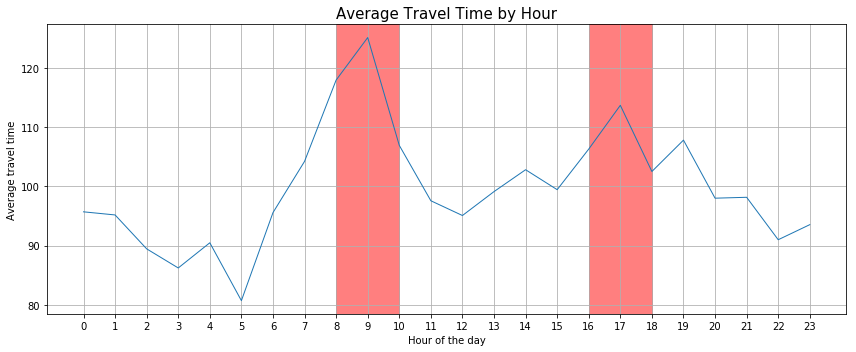

In [44]:
fig, ax = plt.subplots(figsize = (12,5))
ax.plot(hour_stream.index,hour_stream['travel_time'], linestyle='-', linewidth=1, label='travel time')
ax.set_xticks(hour_stream.index)
ax.axvspan(8, 10, alpha=0.5, color='red')
ax.axvspan(16, 18, alpha=0.5, color='red')
plt.xlabel('Hour of the day')
plt.ylabel('Average travel time')
plt.title('Average Travel Time by Hour', fontsize=15)
plt.tight_layout()
plt.grid()
plt.savefig('Travel time by hour')

In [45]:
def PeakOrNot(timestamp):
    '''
    peak -- 8 to 10, 16 to 18
    offpeak -- rest hours
    '''
    hour = timestamp.hour
    if (hour <= 10 and hour >= 8) or (hour <= 18 and hour >= 16):
        return 'peak'
    else:
        return 'offpeak'

In [46]:
V_df['PeakOrNot'] = V_df['starting_time'].apply(lambda x: PeakOrNot(x))

In [47]:
V_df.head()

link_id,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,starting_time,travel_time,route,avg_wid,avg_len,loc_time,same_route_cars,weather,PeakOrNot
vehicle_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1065642,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,2016-07-19 00:14:24,70.85,B_3,7,95,"(0, B)",1,0,offpeak
1047198,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,2016-07-19 00:35:56,148.79,B_3,7,95,"(5, B)",2,0,offpeak
1086390,1,1,0,1,0,1,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,2016-07-19 00:37:15,79.76,B_1,6,91,"(5, B)",2,0,offpeak
1071181,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,2016-07-19 00:37:59,58.05,A_2,7,64,"(5, A)",1,0,offpeak
1065807,1,1,0,1,0,1,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,2016-07-19 00:56:21,137.98,B_1,6,91,"(9, B)",1,0,offpeak


#### daily_feature

In [48]:
day_stream_duration = duration_[['travel_time']].groupby(duration_.index.day).mean()

In [49]:
travel_time = V_df[['travel_time','starting_time']].set_index('starting_time')
travel_time = travel_time['travel_time'].resample('D', how='mean')

/anaconda3/envs/myEnv3/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  


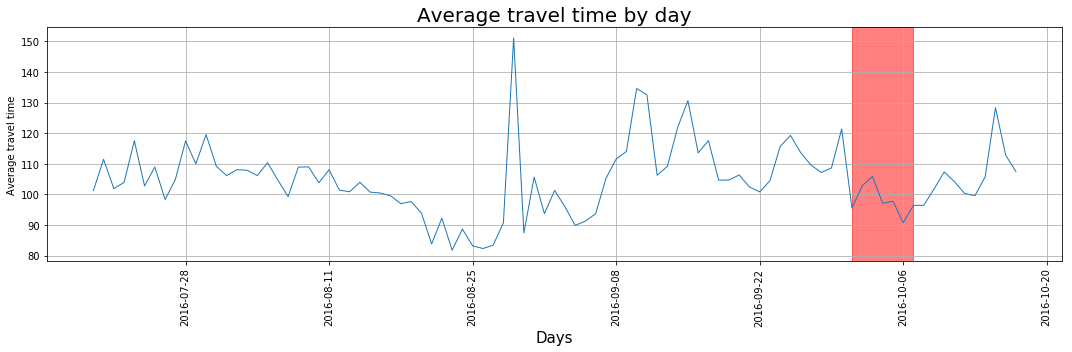

In [50]:
fig, ax = plt.subplots(figsize = (15,5))
ax.plot(travel_time.index,travel_time.values, linestyle='-', linewidth=1, label='travel_time')
# ax.set_xticklabels([str(tick)[5:10] for tick in travel_time.index])
ax.tick_params(axis='x', rotation=90)
ax.axvspan('2016-10-1 00:00:00', '2016-10-7 00:00:00', alpha=0.5, color='red')
plt.xlabel('Days',fontsize=15)
plt.ylabel('Average travel time',fontsize=10)
plt.title('Average travel time by day',fontsize=20)
plt.tight_layout()
plt.grid()
plt.savefig('Average travel time by day')

In [51]:
V_df['starting_time'].iloc[0].day

19

In [52]:
def days_of_month(timestamp):
    '''
    first -- first 10 days of month
    middel -- middle 10 days of month
    last -- last 10 days of month
    '''
    day = timestamp.day
    if day <= 10:
        return 'first'
    elif day > 10 and day <=20:
        return 'middle'
    else:
        return 'last'

In [53]:
V_df['part_of_month'] = V_df['starting_time'].apply(lambda x: days_of_month(x))

In [54]:
V_df.head()

link_id,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,starting_time,travel_time,route,avg_wid,avg_len,loc_time,same_route_cars,weather,PeakOrNot,part_of_month
vehicle_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1065642,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,2016-07-19 00:14:24,70.85,B_3,7,95,"(0, B)",1,0,offpeak,middle
1047198,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,2016-07-19 00:35:56,148.79,B_3,7,95,"(5, B)",2,0,offpeak,middle
1086390,1,1,0,1,0,1,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,2016-07-19 00:37:15,79.76,B_1,6,91,"(5, B)",2,0,offpeak,middle
1071181,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,2016-07-19 00:37:59,58.05,A_2,7,64,"(5, A)",1,0,offpeak,middle
1065807,1,1,0,1,0,1,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,2016-07-19 00:56:21,137.98,B_1,6,91,"(9, B)",1,0,offpeak,middle


#### weekday/weekend

In [55]:
week_stream = duration_.copy()
week_stream['start_time'] = week_stream.index
week_stream.head()

link_id,travel_time,start_time
starting_time,,
2016-07-19 00:14:24,70.85,2016-07-19 00:14:24
2016-07-19 00:35:56,148.79,2016-07-19 00:35:56
2016-07-19 00:37:15,79.76,2016-07-19 00:37:15
2016-07-19 00:37:59,58.05,2016-07-19 00:37:59
2016-07-19 00:56:21,137.98,2016-07-19 00:56:21


In [56]:
week_stream['start_time'] = week_stream.index
week_stream['day_of_week'] = week_stream['start_time'].apply(lambda x: x.weekday()) # get the weekday index, between 0 and 6
week_stream['day_of_week'] = week_stream['day_of_week'].apply(lambda x: calendar.day_name[x])
week_stream = week_stream.groupby('day_of_week').mean()

In [57]:
weekday_sorter = [calendar.day_name[x] for x in range(0,7)]
sorterIndex = dict(zip(weekday_sorter,range(len(weekday_sorter))))
# sorterIndex
week_stream['Day_id'] = week_stream.index
week_stream['Day_id'] = week_stream['Day_id'].map(sorterIndex)
week_stream.sort_values('Day_id', inplace=True)
week_stream.head(7)

link_id,travel_time,Day_id
day_of_week,,
Monday,104.531465,0
Tuesday,100.918319,1
Wednesday,103.977201,2
Thursday,103.899846,3
Friday,103.738693,4
Saturday,109.278898,5
Sunday,100.938130,6


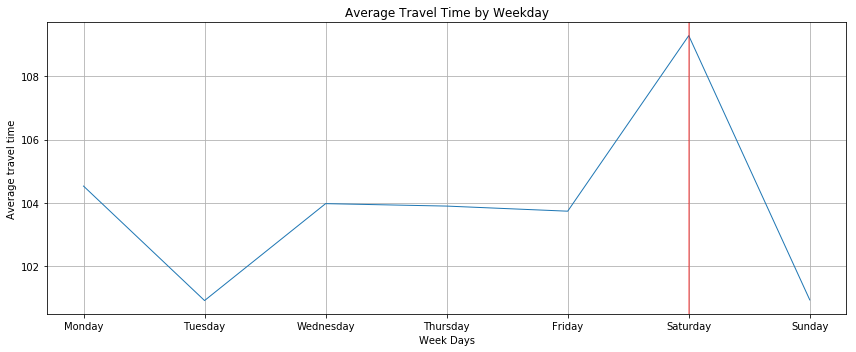

In [58]:
fig, ax = plt.subplots(figsize = (12,5))
ax.plot(week_stream.index,week_stream['travel_time'], linestyle='-', linewidth=1, label='travel time')
ax.set_xticks(week_stream.index)
plt.xlabel('Week Days')
plt.ylabel('Average travel time')
plt.title('Average Travel Time by Weekday')
plt.axvline(x='Saturday', color="red", alpha=0.5)
plt.tight_layout()
plt.grid()
plt.savefig('Travel Time by weekday')

In [59]:
V_df_time = V_df.set_index('starting_time')
V_df_time['vehicle_id'] = V_df.index

In [60]:
V_df['day_of_week'] = V_df['starting_time'].apply(lambda x: x.weekday()) # get the weekday index, between 0 and 6
V_df['day_of_week'] = V_df['day_of_week'].apply(lambda x: calendar.day_name[x])

In [61]:
V_df.head()

link_id,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,starting_time,travel_time,route,avg_wid,avg_len,loc_time,same_route_cars,weather,PeakOrNot,part_of_month,day_of_week
vehicle_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1065642,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,2016-07-19 00:14:24,70.85,B_3,7,95,"(0, B)",1,0,offpeak,middle,Tuesday
1047198,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,2016-07-19 00:35:56,148.79,B_3,7,95,"(5, B)",2,0,offpeak,middle,Tuesday
1086390,1,1,0,1,0,1,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,2016-07-19 00:37:15,79.76,B_1,6,91,"(5, B)",2,0,offpeak,middle,Tuesday
1071181,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,2016-07-19 00:37:59,58.05,A_2,7,64,"(5, A)",1,0,offpeak,middle,Tuesday
1065807,1,1,0,1,0,1,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,2016-07-19 00:56:21,137.98,B_1,6,91,"(9, B)",1,0,offpeak,middle,Tuesday


In [62]:
V_df_ = V_df[["travel_time","avg_wid","avg_len","route","same_route_cars",
             "weather","day_of_week","PeakOrNot",
             "part_of_month","starting_time"]]

## Train/test_split

In [63]:
traintest_split = int(V_df_.shape[0]*0.66)
V_train = V_df_.iloc[:traintest_split, :] 
V_test = V_df_.iloc[traintest_split:, :]

X_train = V_train.drop(columns = {"travel_time"}, axis=1)
y_train = V_train["travel_time"]

X_test = V_test.drop(columns = {"travel_time"}, axis=1)
y_test = V_test["travel_time"]

In [64]:
V_train.to_csv("train.csv")
V_test.to_csv("test.csv")

In [65]:
V_train['route'].unique()

array(['B_3', 'B_1', 'A_2', 'C_3', 'A_3', 'C_1'], dtype=object)

In [66]:
b3_mean = V_train[V_train["route"] == 'B_3']["travel_time"].mean()
b3_median = V_train[V_train["route"] == 'B_3']["travel_time"].median()

In [67]:
b1_mean = V_train[V_train["route"] == 'B_1']["travel_time"].mean()
b1_median = V_train[V_train["route"] == 'B_1']["travel_time"].median()

In [68]:
a2_mean = V_train[V_train["route"] == 'A_2']["travel_time"].mean()
a2_median = V_train[V_train["route"] == 'A_2']["travel_time"].median()

In [69]:
c3_mean = V_train[V_train["route"] == 'C_3']["travel_time"].mean()
c3_median = V_train[V_train["route"] == 'C_3']["travel_time"].median()

In [70]:
a3_mean = V_train[V_train["route"] == 'A_3']["travel_time"].mean()
a3_median = V_train[V_train["route"] == 'A_3']["travel_time"].median()

In [71]:
c1_mean = V_train[V_train["route"] == 'C_1']["travel_time"].mean()
c1_median = V_train[V_train["route"] == 'C_1']["travel_time"].median()

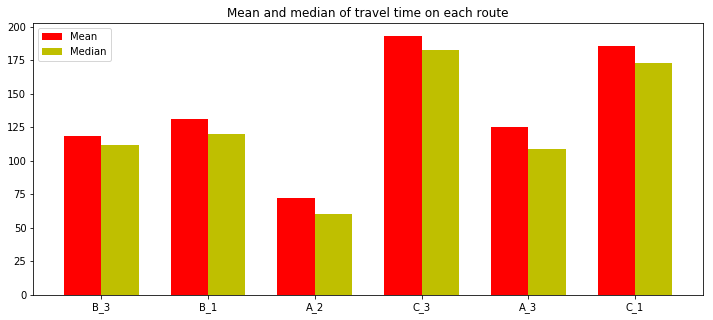

<Figure size 432x288 with 0 Axes>

In [72]:
N = 6
meanRoutes = (b3_mean,b1_mean,a2_mean,c3_mean,a3_mean,c1_mean)
medianRoutes = (b3_median,b1_median,a2_median,c3_median,a3_median,
                c1_median)
fig, ax = plt.subplots(figsize=(12,5))
ind = np.arange(N)    # the x locations for the groups
width = 0.35         # the width of the bars
p1 = ax.bar(ind, meanRoutes, width, color='r')
p2 = ax.bar(ind + width, medianRoutes, width,
            color='y')

ax.set_title('Mean and median of travel time on each route')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('B_3', 'B_1', 'A_2', 'C_3', 'A_3', 'C_1'))

ax.legend((p1[0], p2[0]), ('Mean', 'Median'))
ax.autoscale_view()

plt.show()
plt.savefig('Travel Time by weekday')

## Drop_outliers

In [73]:
def findOutliers(series):
    q3 = series.quantile(0.75)
    q1 = series.quantile(0.25)
    IQR = q3-q1
    upper = q3+1.5*IQR
    lower = q1-1.5*IQR
    outliers =(series > upper)|(series<lower)
    return outliers

In [74]:
outliers = findOutliers(V_train.travel_time)
V_train = V_train[-outliers]
V_train.shape

(69762, 10)

In [75]:
# V_train.to_csv("final.csv")

In [76]:
# V_test.to_csv('final_test.csv')

## Travel_time_histogram

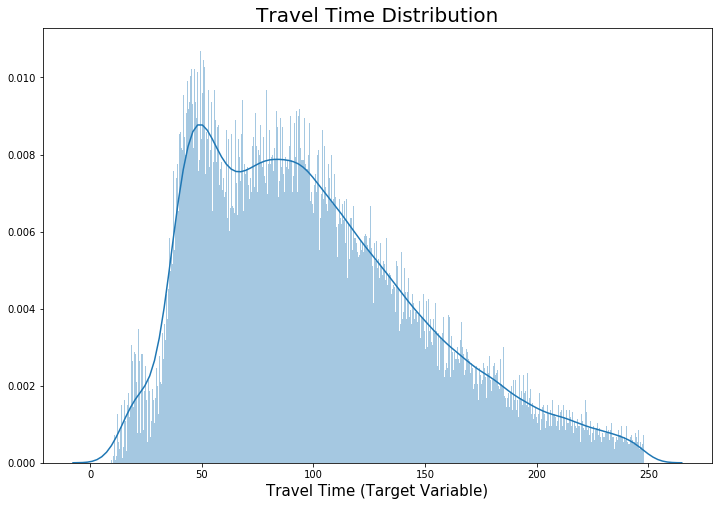

In [77]:
plt.figure(figsize = (12,8))
sns.distplot(V_train["travel_time"], bins = 1000)
plt.title("Travel Time Distribution", fontsize=20)
plt.xlabel("Travel Time (Target Variable)",fontsize=15)
plt.savefig('Travel Time Distribution')

In [78]:
V_train.drop(columns = "starting_time",axis=1, inplace=True)

## Model

In [79]:
V_train.head()

link_id,travel_time,avg_wid,avg_len,route,same_route_cars,weather,day_of_week,PeakOrNot,part_of_month
vehicle_id,,,,,,,,,
1065642,70.85,7,95,B_3,1,0,Tuesday,offpeak,middle
1047198,148.79,7,95,B_3,2,0,Tuesday,offpeak,middle
1086390,79.76,6,91,B_1,2,0,Tuesday,offpeak,middle
1071181,58.05,7,64,A_2,1,0,Tuesday,offpeak,middle
1065807,137.98,6,91,B_1,1,0,Tuesday,offpeak,middle


In [80]:
V_train.columns

Index([u'travel_time', u'avg_wid', u'avg_len', u'route', u'same_route_cars',
       u'weather', u'day_of_week', u'PeakOrNot', u'part_of_month'],
      dtype='object', name=u'link_id')

In [81]:
features1 = ['avg_wid', 'avg_len', 'route', 'same_route_cars']
features2 = ['avg_wid', 'avg_len', 'route', 'same_route_cars', 
             'weather', 'day_of_week', 'PeakOrNot', 'part_of_month']

## Base_Line

In [82]:
array = []
index = []
V_test_route = V_test.route
for route in set(V_train['route']):
    mean = V_train[V_train["route"] == route]["travel_time"].mean()
    median = V_train[V_train["route"] == route]["travel_time"].median() 
    array.append([mean, median])
    index.append(route)
mean_median = pd.DataFrame(array, index = index, columns = ['mean', 'median'])
mean_median

,mean,median
A_3,114.930755,106.700
A_2,69.655373,59.850
C_1,168.422783,165.575
C_3,170.873804,170.710
B_1,122.807419,118.135
B_3,114.097882,110.690


In [83]:
def baseline_prediction(V_test_route, y_test):
    y_pred_mean = []
    y_pred_median = []
    y_pred_mode = []
    for route in V_test_route:
        y_pred_mean.append(mean_median.loc[route, 'mean'])
        y_pred_median.append(mean_median.loc[route, 'median'])
    return y_pred_mean, y_pred_median   

y_pred_mean, y_pred_median = baseline_prediction(V_test_route, y_test)
print('y_pred_mean MAE: ',mean_absolute_error(y_test, y_pred_mean))
print('y_pred_mean RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred_mean)))
print('y_pred_median MAE: ',mean_absolute_error(y_test, y_pred_median))
print('y_pred_median RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred_median)))

('y_pred_mean MAE: ', 32.153189796142492)
('y_pred_mean RMSE: ', 55.069800486418423)
('y_pred_median MAE: ', 30.739757020165307)
('y_pred_median RMSE: ', 55.501198376965206)


## Linear_regression

In [84]:
mod1 = smf.ols(formula=
               'travel_time~avg_wid+avg_len+C(route)+same_route_cars',
              data=V_train).fit()
mod1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            travel_time   R-squared:                       0.421
Model:                            OLS   Adj. R-squared:                  0.421
Method:                 Least Squares   F-statistic:                     6331.
Date:                Thu, 09 May 2019   Prob (F-statistic):               0.00
Time:                        23:03:46   Log-Likelihood:            -3.5243e+05
No. Observations:               69762   AIC:                         7.049e+05
Df Residuals:                   69753   BIC:                         7.050e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          49.5788     14.747      3.362      0.001      20.674      78.483
C(route)[T.A_3]    19.1349      4.578      4.180      0.000      10.163      28.107
C(route)[T.B_1]    39.5367      3.077     12.851      0.000      33.507      45.567
C(route)[T.B_3]    33.3477      3.576      9.325      0.000      26.338      40.357
C(route)[T.C_1]    71.3799      7.486      9.535      0.000      56.707      86.052
C(route)[T.C_3]    70.0729     11.231      6.239      0.000      48.061      92.085
avg_wid            -3.8728      1.528     -2.534      0.011      -6.868      -0.878
avg_len             0.5383      0.115      4.699      0.000       0.314       0.763
same_route_cars     2.7244      0.063     43.271      0.000       2.601       2.848
==============================================================================
Omnibus:                     8894.537   Durbin-Watson:                   1.701
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14150.893
Skew:                           0.900   Prob(JB):                         0.00
Kurtosis:                       4.277   Cond. No.                     1.25e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.25e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [85]:
y_pred = mod1.predict(X_test)
np.sqrt(mean_squared_error(y_test,y_pred))

55.49758018654309

In [86]:
mean_absolute_error(y_test,y_pred)

33.89612396732295

In [87]:
mod2 = smf.ols(formula=
               'travel_time~avg_wid+avg_len+C(route)+same_route_cars+C(weather)+C(day_of_week)+C(PeakOrNot)+C(part_of_month)',
              data=V_train).fit()
mod2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            travel_time   R-squared:                       0.426
Model:                            OLS   Adj. R-squared:                  0.426
Method:                 Least Squares   F-statistic:                     2730.
Date:                Thu, 09 May 2019   Prob (F-statistic):               0.00
Time:                        23:03:49   Log-Likelihood:            -3.5208e+05
No. Observations:               69762   AIC:                         7.042e+05
Df Residuals:                   69742   BIC:                         7.044e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      48.2397     14.682      3.286      0.001      19.463      77.017
C(route)[T.A_3]                18.8477      4.555      4.137      0.000       9.919      27.776
C(route)[T.B_1]                38.9831      3.062     12.732      0.000      32.982      44.984
C(route)[T.B_3]                32.3763      3.559      9.097      0.000      25.401      39.352
C(route)[T.C_1]                69.6766      7.450      9.353      0.000      55.075      84.278
C(route)[T.C_3]                68.0521     11.176      6.089      0.000      46.147      89.957
C(weather)[T.1]                 0.1171      0.349      0.336      0.737      -0.566       0.800
C(weather)[T.2]                -2.4154      0.411     -5.872      0.000      -3.222      -1.609
C(day_of_week)[T.Monday]       -0.8273      0.547     -1.511      0.131      -1.900       0.246
C(day_of_week)[T.Saturday]      1.8726      0.515      3.636      0.000       0.863       2.882
C(day_of_week)[T.Sunday]       -1.4647      0.534     -2.744      0.006      -2.511      -0.419
C(day_of_week)[T.Thursday]     -1.3916      0.534     -2.606      0.009      -2.438      -0.345
C(day_of_week)[T.Tuesday]      -2.6547      0.530     -5.008      0.000      -3.694      -1.616
C(day_of_week)[T.Wednesday]    -0.4283      0.530     -0.808      0.419      -1.467       0.611
C(PeakOrNot)[T.peak]            6.9412      0.298     23.289      0.000       6.357       7.525
C(part_of_month)[T.last]       -2.1108      0.372     -5.670      0.000      -2.840      -1.381
C(part_of_month)[T.middle]      0.0178      0.398      0.045      0.964      -0.763       0.799
avg_wid                        -3.6769      1.521     -2.418      0.016      -6.657      -0.696
avg_len                         0.5501      0.114      4.826      0.000       0.327       0.774
same_route_cars                 2.4086      0.064     37.405      0.000       2.282       2.535
==============================================================================
Omnibus:                     8637.743   Durbin-Watson:                   1.716
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13620.889
Skew:                           0.882   Prob(JB):                         0.00
Kurtosis:                       4.255   Cond. No.                     1.25e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.25e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [88]:
y_pred = mod2.predict(X_test)
np.sqrt(mean_squared_error(y_test,y_pred))

55.333211348791117

In [89]:
mean_absolute_error(y_test,y_pred)

33.611769758825908

In [90]:
mod2.compare_lr_test(mod1)

(704.95875596615952, 4.6661668176498775e-144, 11.0)

## random_forest

In [91]:
V_test_time = V_test.starting_time
V_test.drop(columns = ['starting_time'], axis = 1, inplace = True)
V_test_route = V_test.route

cat_columns = ['route', 'weather', 'day_of_week', 'PeakOrNot', 'part_of_month']

X_train = V_train.iloc[:,1:]
X_train = pd.get_dummies(X_train, prefix_sep="_", columns=cat_columns)
y_train = V_train.travel_time

X_test = V_test.iloc[:,1:]
X_test = pd.get_dummies(X_test, prefix_sep="_", columns=cat_columns)
y_test = V_test.travel_time

/anaconda3/envs/myEnv3/lib/python2.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


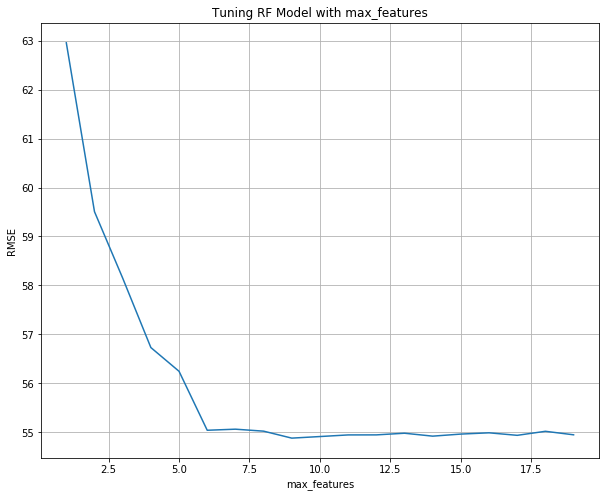

In [92]:
OS = []
RMSE = []
MAE = []
# for i in range(1,11):
for i in range(1,20):
    rf = RandomForestRegressor(max_depth = 4, max_features = i, n_estimators = 6)
    rf.fit(X_train,y_train)
    OS.append(rf.score(X_test, y_test))
    y_pred = rf.predict(X_test)
    mse_ = mean_squared_error(y_test, y_pred)
    mae_ = mean_absolute_error(y_test, y_pred)

    RMSE.append(np.sqrt(mse_))
    MAE.append(mae_)

plt.figure(figsize=(10,8))
plt.plot(list(range(1,20)), RMSE)
plt.xlabel('max_features')
plt.ylabel('RMSE')
plt.title('Tuning RF Model with max_features')
plt.grid()
plt.savefig('Tuning RF Model with max_features')

In [93]:
rf = RandomForestRegressor(max_depth = 4, max_features = 8, n_estimators = 6)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
mse_ = mean_squared_error(y_test, y_pred)
mae_ = mean_absolute_error(y_test, y_pred)


print("OS R-Square: ", np.mean(OS))
print("RMSE: ", np.sqrt(mse_))
print("MAE: ", mae_)

('OS R-Square: ', 0.30374179314119959)
('RMSE: ', 54.992196233543588)
('MAE: ', 32.36542385592503)


In [119]:
print(y_test.mean())
print(y_test.std())
print(y_pred.mean())
print(y_pred.std())

104.028271545
67.1074689743
107.588
33.9328


## xgboost

In [110]:
y_train = y_train.as_matrix()
x_train = X_train.as_matrix()
x_test = X_test.as_matrix()

/anaconda3/envs/myEnv3/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [102]:
xgb_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, )
parameters = {
        'learning_rate': [0.4,0.5,0.6],
        'alpha': [6,8,10],
        'n_estimators': [14,16,18]
    }
clf = GridSearchCV(xgb_reg, parameters, n_jobs=1, cv=2)
clf.fit(x_train,y_train)

GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.3, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid={'n_estimators': [14, 16, 18], 'alpha': [6, 8, 10], 'learning_rate': [0.4, 0.5, 0.6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [103]:
best_parameters = clf.best_params_
best_parameters

{'alpha': 6, 'learning_rate': 0.4, 'n_estimators': 18}

In [117]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.1, learning_rate = 0.4,
                max_depth = 3, alpha = 6, n_estimators = 18, scoring='radada')

xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X_test)
mae1 = mean_absolute_error(y_test, preds)
print("MAE: %f" % (mae1))
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("rmse: %f" % (rmse))

MAE: 32.986668
rmse: 55.631820


In [111]:
y_pred = clf.predict(x_test)

Text(0.5,1,'XGB pred/actual')

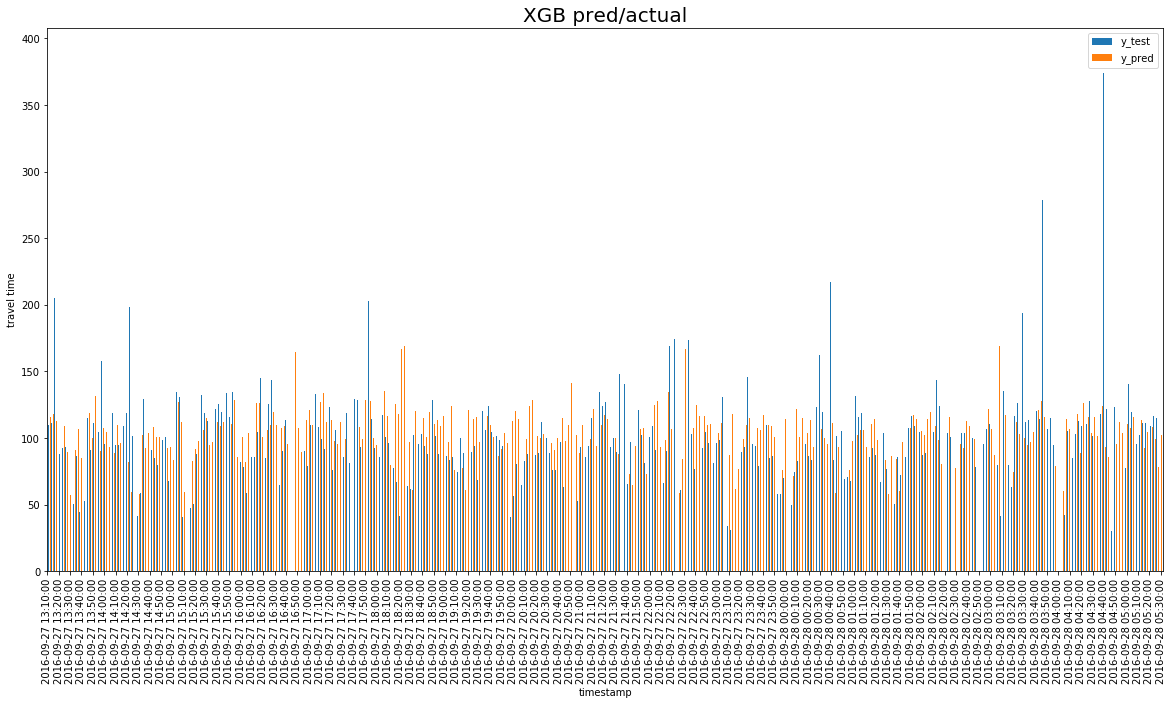

In [123]:
results_df = pd.DataFrame()
results_df['time'] = pd.to_datetime(V_test_time)
results_df['y_test'] = y_test
results_df['y_pred'] = y_pred

temp = results_df.set_index('time')
temp = temp.groupby(pd.Grouper(freq='10Min', base=30, label='right')).mean()
ax = temp.plot(figsize = (20,10), kind = 'bar', xticks = None)
ax.set_xlabel("timestamp")
ax.set_ylabel('travel time')
max_xticks = 100
xloc = plt.MaxNLocator(max_xticks)
ax.xaxis.set_major_locator(xloc)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
ax.set_title('XGB pred/actual',fontsize=20)
# plt.savefig('XGB_pred/actua')

## Conclusion

Accurately measuring travel time can help predict congestions in the road network. Such information could be valuable to traffic operators and policymakers. In this study, our models fail to beat the baseline. While this is discouraging, we do investigate the problem and find ways to improve our models in the future. We believe that we should generate more features that have stronger predictive power. Specifically, more features that can accurately capture traffic condition and route network should be incorporated into the models.